<a href="https://colab.research.google.com/github/leupimik/fishapp_modeltraining/blob/main/ML_Modell_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import der einzelnen Bibliotheken

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile


In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#local_zip = "/content/gdrive/MyDrive/Daten_Images/Species_short.zip"

In [ ]:

#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/content/gdrive/MyDrive/Test')
#zip_ref.close()


In [3]:
local_file = '/content/gdrive/MyDrive/Test/Species_short'

In [4]:
PATH = os.path.join(os.path.dirname(local_file), 'Species_short')

In [5]:
train_dir = os.path.join(PATH, 'Training_Set')
validation_dir = os.path.join(PATH, 'Test_Set')

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5100 files belonging to 3 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 900 files belonging to 3 classes.


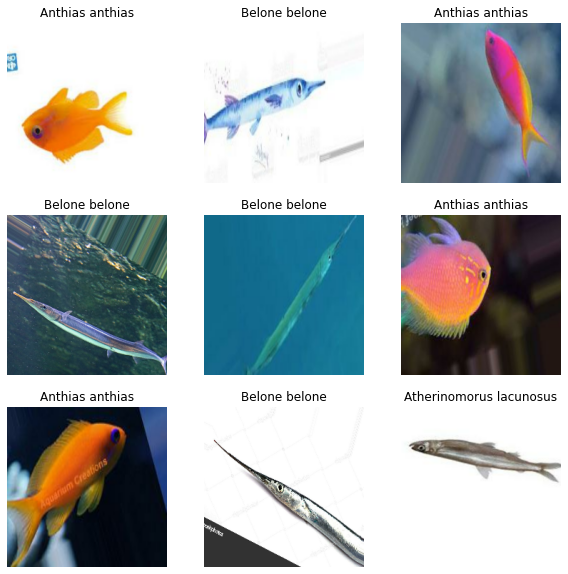

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 160
Number of test batches: 24


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

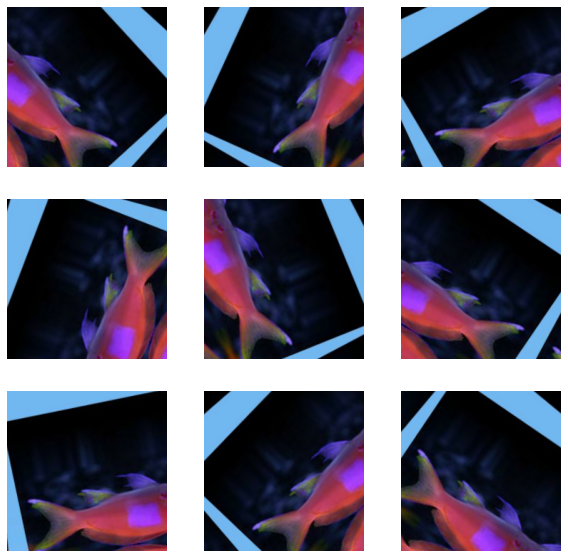

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale Pixel Values

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from the pre-trained convnets

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


Feature extraction

Freeze the convolutional base

In [19]:
base_model.trainable = False

Important note about BatchNormalization layers

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Add a classification head

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
len(model.trainable_variables)

2

Train the model

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

24/24 [==============================] - 136s 3s/step - loss: 0.6649 - accuracy: 0.3135


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.31


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
160/160 [==============================] - 555s 3s/step - loss: -0.3407 - accuracy: 0.3924 - val_loss: -1.1347 - val_accuracy: 0.4095
Epoch 2/10
160/160 [==============================] - 20s 120ms/step - loss: -1.7234 - accuracy: 0.4520 - val_loss: -2.3473 - val_accuracy: 0.4608
Epoch 3/10
160/160 [==============================] - 20s 120ms/step - loss: -3.0465 - accuracy: 0.4729 - val_loss: -3.7372 - val_accuracy: 0.4459
Epoch 4/10
160/160 [==============================] - 20s 121ms/step - loss: -4.3857 - accuracy: 0.4702 - val_loss: -5.2381 - val_accuracy: 0.4486
Epoch 5/10
160/160 [==============================] - 20s 121ms/step - loss: -5.7949 - accuracy: 0.4704 - val_loss: -6.5809 - val_accuracy: 0.4392
Epoch 6/10
160/160 [==============================] - 20s 120ms/step - loss: -7.1037 - accuracy: 0.4647 - val_loss: -7.7921 - val_accuracy: 0.4446
Epoch 7/10
160/160 [==============================] - 21s 129ms/step - loss: -8.4484 - accuracy: 0.4667 - val_loss: -8.9

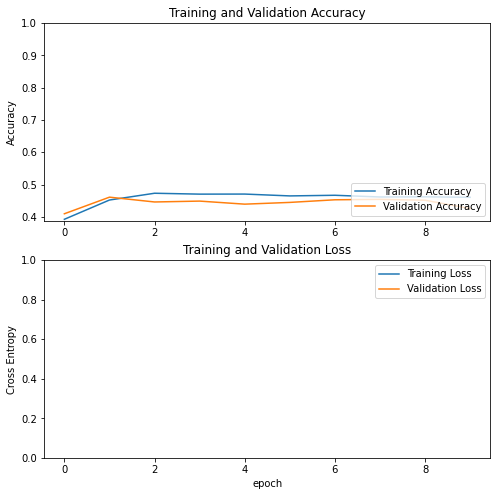

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning

Un-freeze the top layers of the model

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compile the model

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [36]:
len(model.trainable_variables)

56

Continue training the model

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
160/160 [==============================] - 28s 133ms/step - loss: -132.3990 - accuracy: 0.4529 - val_loss: -179.9876 - val_accuracy: 0.5324
Epoch 11/20
160/160 [==============================] - 22s 134ms/step - loss: -188.8122 - accuracy: 0.5947 - val_loss: -190.9638 - val_accuracy: 0.6419
Epoch 12/20
160/160 [==============================] - 21s 126ms/step - loss: -197.0614 - accuracy: 0.6376 - val_loss: -198.8591 - val_accuracy: 0.6405
Epoch 13/20
160/160 [==============================] - 21s 126ms/step - loss: -201.1229 - accuracy: 0.6482 - val_loss: -204.0811 - val_accuracy: 0.6554
Epoch 14/20
160/160 [==============================] - 21s 126ms/step - loss: -204.3175 - accuracy: 0.6529 - val_loss: -203.9144 - val_accuracy: 0.6581
Epoch 15/20
160/160 [==============================] - 21s 126ms/step - loss: -207.8324 - accuracy: 0.6573 - val_loss: -212.1875 - val_accuracy: 0.6595
Epoch 16/20
160/160 [==============================] - 21s 126ms/step - loss: -211.0076 

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

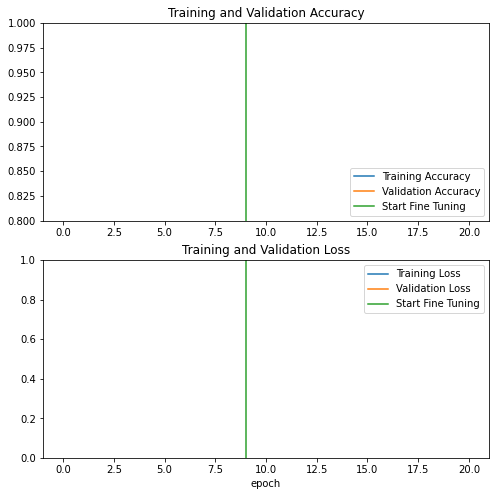

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [40]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 89ms/step - loss: -214.7366 - accuracy: 0.6812
Test accuracy : 0.6812499761581421


Predictions:
 [1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1]
Labels:
 [1 2 0 0 1 2 1 2 2 0 2 1 2 0 0 0 2 1 0 1 0 1 1 1 2 1 1 2 0 0 1 1]


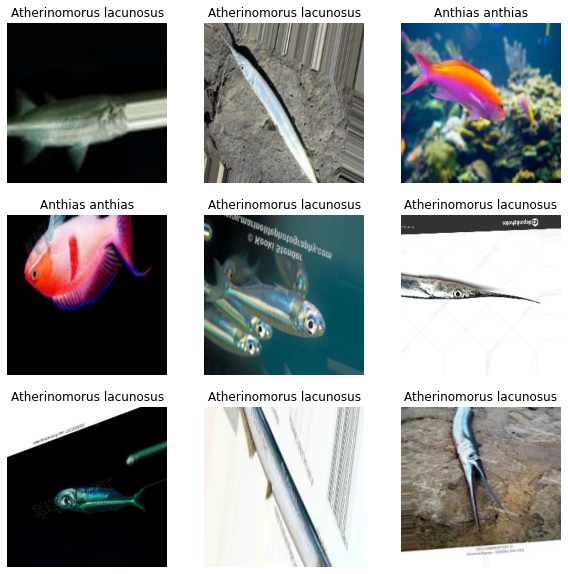

In [41]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")